# 从图像学习神经网络

使用 `CIFAR-10` 模型学习，它由 60000 张微小的图像组成，用一个整数对应 10 个级别中的一个：飞机（0）、汽车（1）、鸟（2）、猫（3）、鹿（4）、狗（5）、青蛙（6）、马（7）、船（8）、卡车（9）。

使用 `TorchVision` 模块的 `datasets` 模块下载 `CIFAR-10` 数据：

In [1]:
from torchvision import datasets

data_path = "../data-unversioned/p1ch7/"
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


下载完数据后，数据集都作为了 `torch.utils.data.Dataset` 的子类方法返回，可以通过实例中的方法解析顺序看到它的父类：

In [2]:
type(cifar10).__mro__

(torchvision.datasets.cifar.CIFAR10,
 torchvision.datasets.vision.VisionDataset,
 torch.utils.data.dataset.Dataset,
 typing.Generic,
 object)

## Dataset 类

`Dataset` 是需要实现两个方法的对象： `__len__()` 和 `__getitem__()` ，前者返回数据中的项数，后者返回由样本和与之相对应的标签（整数索引）组成的项。在实践中，当一个 `Python` 对象实现了 `__len__()` 方法时，可以将其作为参数传递给 `Python` 的内置函数 `len()`:

In [3]:
len(cifar10), len(cifar10_val)

(50000, 10000)

类似地，由于 `Dataset` 实现了 `__get_item__()` 方法，我们可以使用标准索引对元组或列表进行索引访问单个项。在这个例子中，我们得到一个带有期望输出的 PIL(Python Imaging Library) 图像，输出值为 1 ，对应图像数据集中的 *汽车* ：

In [4]:
image, label = cifar10[99]
image,label

(<PIL.Image.Image image mode=RGB size=32x32>, 1)

这个图像可以由 `matplotlib` 画出来：

<function matplotlib.pyplot.show(close=None, block=None)>

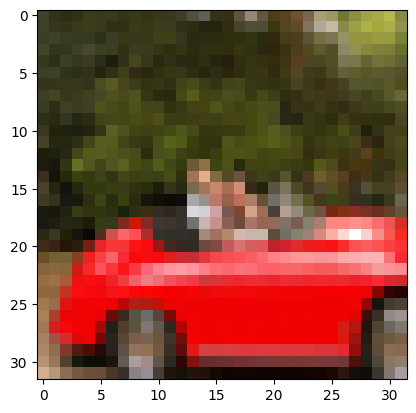

In [5]:
from matplotlib import pyplot as plt
plt.imshow(image)
plt.show

### Dataset 变换

我们现在已经获取到了图像数据，但是还需要一种办法来将 `PIL` 图像转换成 `PyTorch` 张量，这样我们才能使用图像来做一些其他的事，因此需要导入 `torchvision.transforms` 模块。这个模块定义了一组可组合的、类似于函数的对象，它可以作为参数传递到 `TorchVision` 模块的数据集，在数据加载之后、 `__getitem__()` 方法返回之前对数据进行变换。我们可以先看看可用对象的列表：

In [6]:
from torchvision import transforms
dir(transforms)

['AugMix',
 'AutoAugment',
 'AutoAugmentPolicy',
 'CenterCrop',
 'ColorJitter',
 'Compose',
 'ConvertImageDtype',
 'ElasticTransform',
 'FiveCrop',
 'GaussianBlur',
 'Grayscale',
 'InterpolationMode',
 'Lambda',
 'LinearTransformation',
 'Normalize',
 'PILToTensor',
 'Pad',
 'RandAugment',
 'RandomAdjustSharpness',
 'RandomAffine',
 'RandomApply',
 'RandomAutocontrast',
 'RandomChoice',
 'RandomCrop',
 'RandomEqualize',
 'RandomErasing',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomInvert',
 'RandomOrder',
 'RandomPerspective',
 'RandomPosterize',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSolarize',
 'RandomVerticalFlip',
 'Resize',
 'TenCrop',
 'ToPILImage',
 'ToTensor',
 'TrivialAugmentWide',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_functional_pil',
 '_functional_tensor',
 '_presets',
 'autoaugment',
 'functional',
 'transforms']

在这些变化对象中，可以看到 `ToTensor` 对象，它将 `NumPy` 数组和 `PIL` 图像变换成张量。它还将输出张量的尺寸设置为 `C*H*W` ，这正是我们所需要的。现在先来试一试 `ToTensor` 变换：

In [7]:
to_tensor = transforms.ToTensor()
img_t = to_tensor(image)
img_t.shape

torch.Size([3, 32, 32])

图像已变换成 3 * 32 * 32 的张量，即一个有 3 个通道 (RGB) 的 32 * 32 的图像，这正是我们期望的，现在我们可以将变换作为参数直接传入：

In [8]:
tensor_cifar10 = datasets.CIFAR10(data_path,
                                  train=True,
                                  download=False,
                                  transform=transforms.ToTensor())

此时访问元素数据将返回一个张量，而不是 PIL 图像：

In [9]:
img_t, _ = tensor_cifar10[99]
type(img_t)

torch.Tensor

In [10]:
img_t.shape, img_t.dtype

(torch.Size([3, 32, 32]), torch.float32)

可以看到正如预期的那样，形状的第一维是通道，而标量类型是 `float32` 。原始的 PIL 图像中的值为 0～255 （RGB），而 `ToTensor` 变换为每个通道的 32 位浮点数，将其值缩小为 0.0～1.0 ，可以验证一下：

In [11]:
img_t.min(), img_t.max()

(tensor(0.), tensor(1.))

在验证一下得到的图像是否相同：

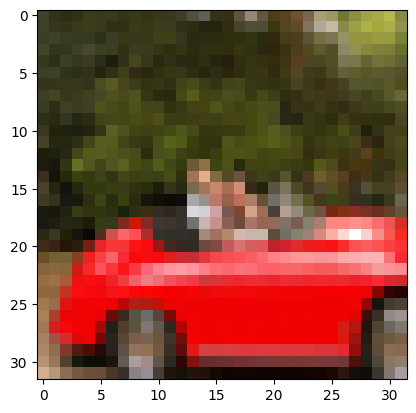

In [12]:
plt.imshow(img_t.permute(1, 2, 0))
plt.show()

可以看到得到的数据和之前是一样的

### 数据归一化

数据变化非常方便，我们可以通过 `transforms.Compose()` 将它们连接起来，然后在数据加载器中透明的进行数据归一化和数据增强操作。

现在开始尝试进行归一化：*每个通道的平均值为 0 ,标准差为 1* 。归一化的的原因主要是：可以通过选择在 0±1（或 2 ） 附近呈线性的激活函数，将数据保持在相同的范围内且更有可能具有非零梯度，在这种情况下可以更快的进行学习；同时，对每个通道进行归一化，使其具有相同的分布，可以在保证相同的学习率下，通过剃度下降实现通道信息的混合和更新。

`进行归一化的主要原因是为了让数据保持在相同的范围内并更容易进行学习。通过归一化，数据的分布可以更加均匀，可以避免某些特征对模型的影响过大，提高模型的稳定性和泛化能力。此外，归一化后的数据可以更容易地选择合适的激活函数，并且在训练时更容易收敛。在实际应用中，归一化技术已经被广泛应用于各种深度学习模型中，包括卷积神经网络、循环神经网络等。`

为了使每个通道的均值为 0 ，标准差为 1 ，可以应用以下转换来计算数据集中每个通道的平均值和标准差：
` v_n[c] = (v[c] - mean[c])/stdev[c] `
需要注意的是平均值和标准差都需要离线计算，现在让我们计算 `CIFAR-10` 训练集的平均值和标准差。

首先需要返回数据集中所有的数据，并将他们在一个额外的维度上进行堆叠（计算整个数据集上的平均值和标准差）：

In [13]:
import torch
imgs = torch.stack([img_t for img_t,_ in tensor_cifar10], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

现在我们可以很容易的计算出每个信道的平均值和标准差：

In [14]:
# 只保留了第一维，即三个通道，并将剩余的维度合并成一个维度
mean = imgs.view(3, -1).mean(dim=1)
std = imgs.view(3, -1).std(dim=1)
mean, std

(tensor([0.4914, 0.4822, 0.4465]), tensor([0.2470, 0.2435, 0.2616]))

有了这些数据就可以使用 `Normalize` 变换了。
接下来将其连接到 `ToTensor` 变换：

In [16]:
transformed_cifar10 = datasets.CIFAR10(data_path,
                 train=True,
                 download=False,
                 transform=transforms.Compose([
                     transforms.ToTensor(),
                     transforms.Normalize((0.4914, 0.4822, 0.4465),
                                          (0.2470, 0.2435, 0.2616))
                 ]))

注意，此时从数据集绘制的图像不能为我们提供真实的图像：

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


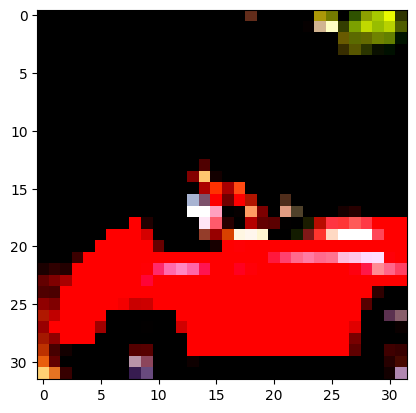

In [18]:
img_t, _ = transformed_cifar10[99]
plt.imshow(img_t.permute(1, 2, 0))
plt.show()

上面就是重新归一化后得到的红色汽车的图像，归一化对 RGB 超过 0.0~1.0 的数据进行了转化，并调整了通道大小，但所有数据任然存在，只是将其渲染成了黑色。